In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../../../")
from src.athena import Athena
from src.utils import create_session

## Global

In [2]:
boto3_session = create_session(
    profile_name="dev",
    role_arn="arn:aws:iam::722696965592:role/athena-full-access-role",
)

wait = True
ctas_approach = False

table = "daily_btc"
database = "trading"

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv("ATHENA_S3_OUTPUT"))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Fill `NULL` Values

Using the propagation of `NULL` values, we can find all rows with `NULL` values in any `NUMERIC` column by summing all columns in a `WHERE` clause. If the sum is `NULL`, then the row has a `NULL` value in at least one column.

In [5]:
query = """ 
SELECT 
    *
FROM 
    trading.daily_btc
WHERE (open_price + high_price + low_price + close_price + adjusted_close_price + volume) IS NULL;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,market_date,open_price,high_price,low_price,close_price,adjusted_close_price,volume
0,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


### Fill `NULL` Values with `LAG` & `Coalesce`

#### LAG

The `LAG` function takes an input expression, i.e., a column, expression, or subquery, and returns the value of that expression evaluated at the row that is `offset` rows before the current row. If there is no such row, the function returns the `default_value` if it is specified, otherwise it returns `NULL`.

```sql
LAG(expression [,offset [,default_value]]) 
OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC | DESC], ...
)
```

* `expression`: The expression must return a single value, e.g., a column, expression, or subquery, and it cannot be a window function.

* `offset`: The offset is a positive integer that specifies the number of rows that come before the current row from which to access data. The offset can be an expression, subquery, or column. It defaults to 1 if not specified.

* `default_value`: The default value is the value that the function returns if there is no row that is `offset` rows before the current row.

#### COALESCE

The `COALESCE` function returns the first non-`NULL` value in the list of arguments. If all arguments are `NULL`, the function returns `NULL`. The function evaluates arguments in order and returns the first value that is not `NULL`; if a non-`NULL` value is found, all subsequent arguments are not evaluated.

```sql
COALESCE (argument_1, argument_2, …)
```

Since there may be more than one consecutive missing rows, we supply two `LAG` functions to fill the `NULL` values:

* `LAG(column, 1)`: This fills each `NULL` row with the previous day's value.

* `LAG(column, 2)`: This fills the `NULL` row with the value from two days ago.

We can create a view:

In [6]:
query = """
CREATE OR REPLACE VIEW updated_daily_btc AS
SELECT
    market_date,
    COALESCE(
        open_price,
        LAG(open_price, 1) OVER w,
        LAG(open_price, 2) OVER w
    ) AS open_price,
    COALESCE(
        high_price,
        LAG(high_price, 1) OVER w,
        LAG(high_price, 2) OVER w
    ) AS high_price,
    COALESCE(
        low_price,
        LAG(low_price, 1) OVER w,
        LAG(low_price, 2) OVER w
    ) AS low_price,
    COALESCE(
        close_price,
        LAG(close_price, 1) OVER w,
        LAG(close_price, 2) OVER w
    ) AS close_price,
    COALESCE(
        adjusted_close_price,
        LAG(adjusted_close_price, 1) OVER w,
        LAG(adjusted_close_price, 2) OVER w
    ) AS adjusted_close_price,
    COALESCE(
        volume,
        LAG(volume, 1) OVER w,
        LAG(volume, 2) OVER w
    ) AS volume
FROM 
    trading.daily_btc
WINDOW
    w AS (ORDER BY market_date);
"""

athena.create_view(database=database, query=query, wait=wait)

Query executed successfully


Check that the missing rows are imputed:

In [7]:
query = """
SELECT
    *
FROM
    trading.updated_daily_btc
WHERE market_date IN (
    DATE '2020-04-16',
    DATE '2020-04-17',
    DATE '2020-10-08',
    DATE '2020-10-09',
    DATE '2020-10-11',
    DATE '2020-10-12',
    DATE '2020-10-13'
);
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,market_date,open_price,high_price,low_price,close_price,adjusted_close_price,volume
0,2020-04-16,6640.454102,7134.450684,6555.504395,7116.804199,7116.804199,4.678324e+10
1,2020-04-17,6640.454102,7134.450684,6555.504395,7116.804199,7116.804199,4.678324e+10
2,2020-10-08,10677.625000,10939.799805,10569.823242,10923.627930,10923.627930,2.196212e+10
3,2020-10-09,10677.625000,10939.799805,10569.823242,10923.627930,10923.627930,2.196212e+10
4,2020-10-11,11296.082031,11428.813477,11288.627930,11384.181641,11384.181641,1.996863e+10
5,2020-10-12,11296.082031,11428.813477,11288.627930,11384.181641,11384.181641,1.996863e+10
6,2020-10-13,11296.082031,11428.813477,11288.627930,11384.181641,11384.181641,1.996863e+10


## Cumulative Volume

### Self-Join

The first approach to compute the cumulative (running) trade volume is to use a self-join:

In [8]:
query = """ 
WITH volume_data AS (
    SELECT
        market_date,
        volume
    FROM
        trading.updated_daily_btc
    LIMIT 5
)
SELECT
    vd1.market_date AS vd1_market_date,
    vd1.volume AS vd1_volume,
    vd2.market_date AS vd2_market_date,
    vd2.volume AS vd2_volume
FROM
    volume_data AS vd1 
    INNER JOIN volume_data AS vd2 ON vd1.market_date >= vd2.market_date
ORDER BY
    vd1.market_date,
    vd1.volume,
    vd2.market_date,
    vd2.volume;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,vd1_market_date,vd1_volume,vd2_market_date,vd2_volume
0,2014-09-17,21056800.0,2014-09-17,21056800.0
1,2014-09-18,34483200.0,2014-09-17,21056800.0
2,2014-09-18,34483200.0,2014-09-18,34483200.0
3,2014-09-19,37919700.0,2014-09-17,21056800.0
4,2014-09-19,37919700.0,2014-09-18,34483200.0
5,2014-09-19,37919700.0,2014-09-19,37919700.0
6,2014-09-20,36863600.0,2014-09-17,21056800.0
7,2014-09-20,36863600.0,2014-09-18,34483200.0
8,2014-09-20,36863600.0,2014-09-19,37919700.0
9,2014-09-20,36863600.0,2014-09-20,36863600.0


#### Cartesian Product

The self-join results in a cartesian product, also known as a cross join:

```sql
INNER JOIN volume_data AS vd2 ON vd1.market_date >= vd2.market_date
```

The self-join creates pairs of market dates and volumes, where each date is paired with all previous dates. Each date (i.e., a row in `vd1.market_date`) is paired with all earlier and equal dates (i.e., multiple rows in `vd2.market_date`), providing a basis to sum volumes up to the current date.

#### Order By

The `ORDER BY` clause in the query sorts the results:

1. `vd1.market_date`: This sorts the primary rows by `market_date` in `vd1`, ensuring that we are looking at the primary dates in chronological order.

2. `vd1.volume`: If there are multiple entries for the same `vd1.market_date`, as they are paired with all earlier dates, this will sort those entries by `volume`.

3. `vd2.market_date`: This sorts the paired rows (dates in `vd2` that are earlier than or equal to `vd1.market_date`) in chronological order within each primary date.

4. `vd2.volume`: If there are multiple entries with unique volume values for the same pair of `vd1.market_date` and `vd2.market_date`, this will sort those entries by volume.

To completely the cumulative volume calculation, we simply add a `SUM` function to sum the `vd2.volume` column for each unique combination of `vd1.market_date` and `vd1.volume`:

In [9]:
query = """
WITH volume_data AS (
    SELECT
        market_date,
        volume
    FROM
        trading.updated_daily_btc
)
SELECT
    vd1.market_date AS market_date,
    vd1.volume AS volume,
    SUM(vd2.volume) AS running_total_volume
FROM
    volume_data AS vd1 
    INNER JOIN volume_data AS vd2 ON vd1.market_date >= vd2.market_date
GROUP BY
    vd1.market_date,
    vd1.volume
ORDER BY
    vd1.market_date, 
    vd1.volume;
"""

cum_volume = athena.query(database=database, query=query, ctas_approach=ctas_approach)

with pd.option_context("display.float_format", lambda val: f"{val:,.0f}"):
    display(cum_volume)

,market_date,volume,running_total_volume
0,2014-09-17,"21,056,800","21,056,800"
1,2014-09-18,"34,483,200","55,540,000"
2,2014-09-19,"37,919,700","93,459,700"
3,2014-09-20,"36,863,600","130,323,300"
4,2014-09-21,"26,580,100","156,903,400"
...,...,...,...
2348,2021-02-20,"68,145,460,026","24,518,108,881,462"
2349,2021-02-21,"51,897,585,191","24,570,006,466,653"
2350,2021-02-22,"92,052,420,332","24,662,058,886,985"
2351,2021-02-23,"106,102,492,824","24,768,161,379,809"


### Window Function

Another approach to compute the cumulative volume is to use a window function:

In [10]:
query = """ 
WITH volume_data AS (
    SELECT
        market_date,
        volume
    FROM 
      trading.updated_daily_btc
    ORDER BY 
      market_date
)
SELECT
  market_date,
  volume,
  SUM(volume) OVER (ORDER BY market_date RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_sum
FROM 
  volume_data;
"""

cum_volume = athena.query(database=database, query=query, ctas_approach=ctas_approach)

with pd.option_context("display.float_format", lambda val: f"{val:,.0f}"):
    display(cum_volume)

,market_date,volume,cumulative_sum
0,2014-09-17,"21,056,800","21,056,800"
1,2014-09-18,"34,483,200","55,540,000"
2,2014-09-19,"37,919,700","93,459,700"
3,2014-09-20,"36,863,600","130,323,300"
4,2014-09-21,"26,580,100","156,903,400"
...,...,...,...
2348,2021-02-20,"68,145,460,026","24,518,108,881,462"
2349,2021-02-21,"51,897,585,191","24,570,006,466,653"
2350,2021-02-22,"92,052,420,332","24,662,058,886,985"
2351,2021-02-23,"106,102,492,824","24,768,161,379,809"


The window function used here is 

```sql
SUM(volume) OVER (ORDER BY market_date RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
```

#### ORDER BY

The `ORDER BY market_date` clause specifies that the rows should be ordered by the `market_date` column in ascending order, i.e., from the earliest to the latest market date.

#### RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW

This defines the frame of rows over which the window function operates.

- `RANGE BETWEEN UNBOUNDED PRECEDING` means that the window starts from the first row in the partition (since no partition is defined, it starts from the first row of the entire result set).
- `CURRENT ROW` means that the window ends at the current row.

Effectively, this clause ensures that for each row, the window includes all previous rows up to and including the current row. This is why it is used to calculate a cumulative sum, as it sums the `volume` from the row with the earliest `market_date` to the current row.

#### Window Frame Clause

The `RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW` clause is part of the window frame clause, which defines the set of rows over which the window function operates. The window frame clause has the following components:

* **Window Frame Modes**

    - **RANGE**: Defines the window frame based on a logical range of values. For example, `RANGE BETWEEN 5 PRECEDING AND CURRENT ROW` includes the current row and rows within a range of values before it. This mode works with data types with well-defined ranges, such as dates and numbers. 
    
    - **ROWS**: Defines the window frame based on a *physical number of rows*. For example, `ROWS BETWEEN 5 PRECEDING AND CURRENT ROW` includes the current row and the five rows preceding it.
    
    - **GROUPS**: Assigns each row of the result set into a group, similar to the `GROUP BY` clause. The frame starts or ends a specified number of peer groups before or after the current row's peer group. A peer group is a set of rows that are equivalent in the ORDER BY ordering. There must be an `ORDER BY` clause in the window definition to use the `GROUPS` mode.

* **Start and End Frames**

    - **PRECEDING**: Refers to the rows before the current row in the window frame. For example, `3 PRECEDING` means three rows before the current row.
    
    - **FOLLOWING**: Refers to the rows after the current row in the window frame. For example, `3 FOLLOWING` means three rows after the current row.
    
    - **UNBOUNDED**: Extends the window frame to the beginning (`UNBOUNDED PRECEDING`) or the end (`UNBOUNDED FOLLOWING`) of the partition.
    
    - **OFFSET**: Specifies a fixed number of rows or range of values before or after the current row. For example, `5 PRECEDING` or `5 FOLLOWING`.

* **Frame Exclusions**: This option allows rows around the current row to be excluded from the frame, even if they would be included according to the frame start and frame end options.

    - **EXCLUDE CURRENT ROW**: Excludes the current row from the frame.
    
    - **EXCLUDE TIES**: Excludes any peers of the current row from the frame, but not the current row itself. 

    - **EXCLUDE GROUP**: Excludes the current row and its ordering peers from the frame. This removes all rows that are equivalent to the current row in the ORDER BY ordering. For example, `ROWS BETWEEN CURRENT ROW AND 1 FOLLOWING EXCLUDE GROUP` excludes the current row and its peers.
    
    - **EXCLUDE NO OTHERS**: This is the default behavior, which does not exclude any rows from the frame.


<center>

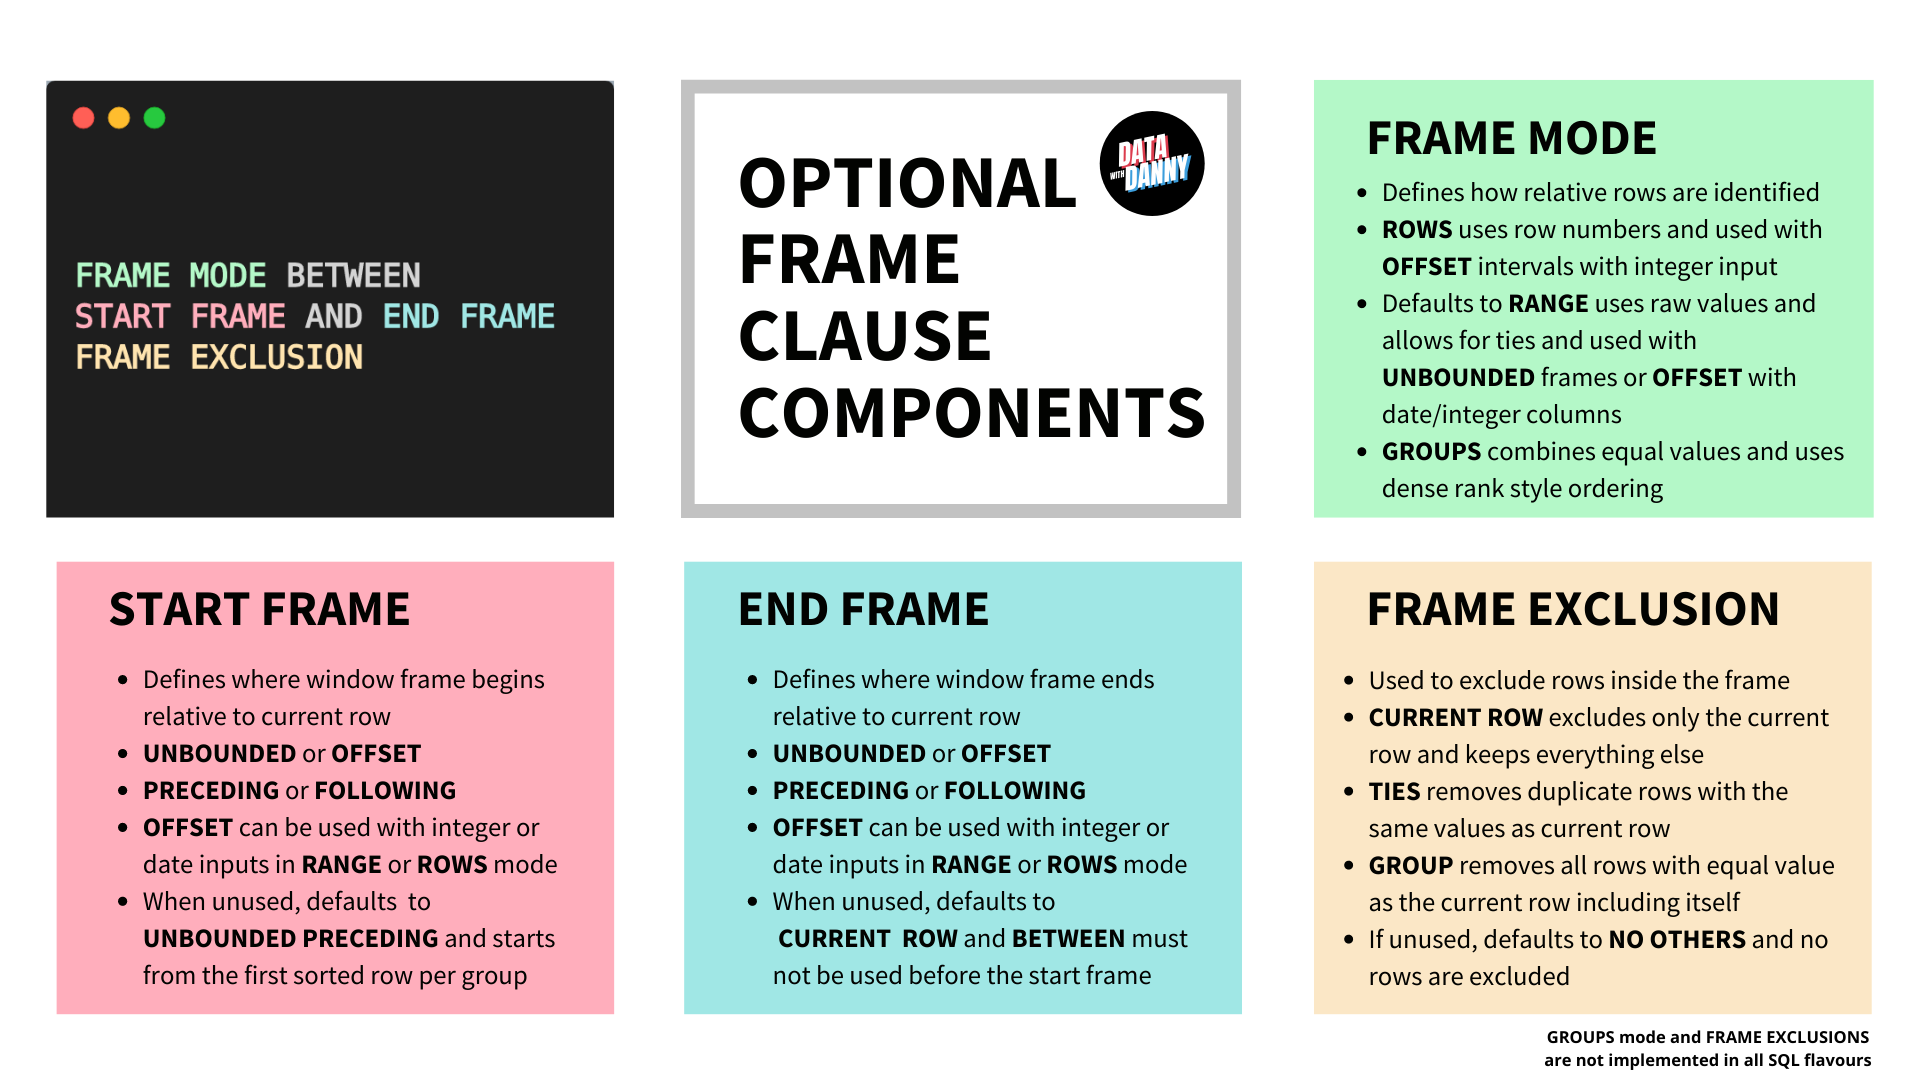

</center>

## Weekly Volume Comparison

We can compute the weekly moving average of the volume of the bitcoin traded in the market. This can be accomplished by a window function:

In [11]:
query = """ 
WITH window_calc AS (
    SELECT
        market_date,
        volume,
        AVG(volume) OVER (
            ORDER BY market_date 
            RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING
        ) AS past_week_avg_volume
    FROM
        trading.updated_daily_btc
)
SELECT
    market_date,
    volume,
    past_week_avg_volume,
    CASE
        WHEN volume > past_week_avg_volume THEN 'Above Past Week Average'
        ELSE 'Below Past Week Average'
    END AS volume_trend
FROM
    window_calc
ORDER BY
    market_date DESC;
"""

volume_trend = athena.query(database=database, query=query, ctas_approach=ctas_approach)

with pd.option_context("display.float_format", lambda val: f"{val:,.4f}"):
    display(volume_trend)

,market_date,volume,past_week_avg_volume,volume_trend
0,2021-02-24,"88,364,793,856.0000","73,509,817,753.4286",Above Past Week Average
1,2021-02-23,"106,102,492,824.0000","69,359,402,048.0000",Above Past Week Average
2,2021-02-22,"92,052,420,332.0000","67,219,042,452.8571",Above Past Week Average
3,2021-02-21,"51,897,585,191.0000","69,983,483,886.7143",Below Past Week Average
4,2021-02-20,"68,145,460,026.0000","70,284,197,619.4286",Below Past Week Average
...,...,...,...,...
2348,2014-09-21,"26,580,100.0000","32,580,825.0000",Below Past Week Average
2349,2014-09-20,"36,863,600.0000","31,153,233.3333",Above Past Week Average
2350,2014-09-19,"37,919,700.0000","27,770,000.0000",Above Past Week Average
2351,2014-09-18,"34,483,200.0000","21,056,800.0000",Above Past Week Average


We compare each day's volume with the average volume of the past 7 days (note: the average calculation does not include the current row). If the volume is higher than the average, the `volume_trend` is 'Above Past Week Average'. If the volume is lower than the average, the `volume_trend` is 'Below Past Week Average'.

```sql
AVG(volume) OVER (
    ORDER BY market_date 
    RANGE BETWEEN INTERVAL '7' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING
) AS past_week_avg_volume
```

The `RANGE` mode uses the logical range of `market_date` values and not the physical range of rows. This ensures that we average over the past 7 days, even if there are missing or mupltiple rows for a day (which is not the case in this data set but may happen in other datasets).

**Note**: Athena's [data manipulation language](https://docs.aws.amazon.com/athena/latest/ug/dml-queries-functions-operators.html) generally support [Trino](https://trino.io/) syntax. In postgresql, we do not need to use the `INTERVERAL` keyword when specifying the range. The following code will work in postgresql:

```sql
  AVG(volume) OVER (
    ORDER BY market_date
    RANGE BETWEEN '7 DAYS' PRECEDING and '1 DAY' PRECEDING
  ) AS past_week_avg_volume
```

## Moving Statistics Close Price

Window functions can be used to compute moving statistics:

In [12]:
query = """ 
SELECT
    market_date,
    close_price,
    -- Moving Average
    ROUND(AVG(close_price) OVER w_14, 2) AS avg_14,
    ROUND(AVG(close_price) OVER w_28, 2) AS avg_28,
    ROUND(AVG(close_price) OVER w_60, 2) AS avg_60,
    ROUND(AVG(close_price) OVER w_150, 2) AS avg_150,
    -- Standard Deviation
    ROUND(STDDEV(close_price) OVER w_14, 2) AS std_14,
    ROUND(STDDEV(close_price) OVER w_28, 2) AS std_28,
    ROUND(STDDEV(close_price) OVER w_60, 2) AS std_60,
    ROUND(STDDEV(close_price) OVER w_150, 2) AS std_150,
    -- Max
    ROUND(MAX(close_price) OVER w_14, 2) AS max_14,
    ROUND(MAX(close_price) OVER w_28, 2) AS max_28,
    ROUND(MAX(close_price) OVER w_60, 2) AS max_60,
    ROUND(MAX(close_price) OVER w_150, 2) AS max_150,
    -- Min
    ROUND(MIN(close_price) OVER w_14, 2) AS min_14,
    ROUND(MIN(close_price) OVER w_28, 2) AS min_28,
    ROUND(MIN(close_price) OVER w_60, 2) AS min_60,
    ROUND(MIN(close_price) OVER w_150, 2) AS min_150
FROM 
    trading.updated_daily_btc
WINDOW
    w_14 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '14' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING),
    w_28 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '28' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING),
    w_60 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '60' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING),
    w_150 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '150' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING)
ORDER BY 
    market_date ASC;
"""

price_stats = athena.query(database=database, query=query, ctas_approach=ctas_approach)

with pd.option_context("display.float_format", lambda val: f"${val:,.4f}"):
    display(price_stats)

,market_date,close_price,avg_14,avg_28,avg_60,avg_150,std_14,std_28,std_60,std_150,max_14,max_28,max_60,max_150,min_14,min_28,min_60,min_150
0,2014-09-17,$457.3340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,$424.4400,$457.3300,$457.3300,$457.3300,$457.3300,NaN,NaN,NaN,NaN,$457.3300,$457.3300,$457.3300,$457.3300,$457.3300,$457.3300,$457.3300,$457.3300
2,2014-09-19,$394.7960,$440.8900,$440.8900,$440.8900,$440.8900,$23.2600,$23.2600,$23.2600,$23.2600,$457.3300,$457.3300,$457.3300,$457.3300,$424.4400,$424.4400,$424.4400,$424.4400
3,2014-09-20,$408.9040,$425.5200,$425.5200,$425.5200,$425.5200,$31.2800,$31.2800,$31.2800,$31.2800,$457.3300,$457.3300,$457.3300,$457.3300,$394.8000,$394.8000,$394.8000,$394.8000
4,2014-09-21,$398.8210,$421.3700,$421.3700,$421.3700,$421.3700,$26.8600,$26.8600,$26.8600,$26.8600,$457.3300,$457.3300,$457.3300,$457.3300,$394.8000,$394.8000,$394.8000,$394.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,2021-02-20,"$56,099.5195","$47,418.8600","$40,661.7700","$36,361.2200","$23,705.9400","$4,517.8900","$7,732.8600","$7,644.9200","$11,792.5300","$55,888.1300","$55,888.1300","$55,888.1300","$55,888.1300","$38,903.4400","$30,432.5500","$23,241.3500","$10,225.8600"
2349,2021-02-21,"$57,539.9453","$48,621.2600","$41,520.0600","$36,899.8300","$24,011.7700","$4,420.1600","$8,069.9700","$7,878.5500","$12,032.9800","$56,099.5200","$56,099.5200","$56,099.5200","$56,099.5200","$38,903.4400","$30,432.5500","$23,241.3500","$10,565.4900"
2350,2021-02-22,"$54,207.3203","$49,952.4300","$42,421.8600","$37,471.4700","$24,323.7300","$4,060.0400","$8,404.1900","$8,111.5900","$12,290.5600","$57,539.9500","$57,539.9500","$57,539.9500","$57,539.9500","$44,918.1800","$30,432.5500","$23,735.9500","$10,565.4900"
2351,2021-02-23,"$48,824.4258","$50,524.6400","$43,201.8900","$37,979.3200","$24,613.7600","$4,054.4700","$8,449.7800","$8,190.5600","$12,478.8400","$57,539.9500","$57,539.9500","$57,539.9500","$57,539.9500","$44,918.1800","$30,432.5500","$24,664.7900","$10,565.4900"


Because the query above invovles multiple window functions, we can name each windowing behavior in a `WINDOW` clause that can be referenced in each `OVER`. This is supported by Trino SQL.

## Weighted Average Close Price

The weighted moving average is computed as follows:

$$ 
\begin{align*}
WMA = \frac{w_1 \cdot x_1 + w_2 \cdot x_2 + \ldots + w_n \cdot x_n}{w_1 + w_2 + \ldots + w_n}
\end{align*}
$$ 

where

* $x_i$ is the value of the time series at time $i$
* $w_i$ is the weight at time $i$

The weights, for example, can be defined as follows:

<center>

| Window | Weight |
|--------|--------|
| 1 - 14 Days | 0.5 |
| 15 - 28 Days | 0.3 |
| 29 - 60 Days | 0.15 |
| 61 - 150 Days | 0.05 |

</center>

In [13]:
query = """
WITH window_calc AS (
    SELECT
        market_date,
        ROUND(close_price, 2) AS close_price,
        -- Moving Average
        ROUND(AVG(close_price) OVER w_1_14, 2) AS avg_1_14,
        ROUND(AVG(close_price) OVER w_15_28, 2) AS avg_15_28,
        ROUND(AVG(close_price) OVER w_29_60, 2) AS avg_29_60,
        ROUND(AVG(close_price) OVER w_61_150, 2) AS avg_61_150
    FROM
        trading.updated_daily_btc
    WINDOW
        w_1_14 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '14' DAY PRECEDING AND INTERVAL '1' DAY PRECEDING),
        w_15_28 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '28' DAY PRECEDING AND INTERVAL '15' DAY PRECEDING),
        w_29_60 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '60' DAY PRECEDING AND INTERVAL '29' DAY PRECEDING),
        w_61_150 AS (ORDER BY market_date RANGE BETWEEN INTERVAL '150' DAY PRECEDING AND INTERVAL '61' DAY PRECEDING)
)
SELECT
    market_date,
    close_price,
    (0.5 * avg_1_14 + 0.3 * avg_15_28 + 0.15 * avg_29_60 + 0.05 * avg_61_150) AS weighted_avg
FROM
    window_calc
ORDER BY
    market_date ASC;
"""

weighted_avg = athena.query(database=database, query=query, ctas_approach=ctas_approach)

with pd.option_context("display.float_format", lambda val: f"${val:,.4f}"):
    display(weighted_avg)

,market_date,close_price,weighted_avg
0,2014-09-17,$457.3300,NaN
1,2014-09-18,$424.4400,NaN
2,2014-09-19,$394.8000,NaN
3,2014-09-20,$408.9000,NaN
4,2014-09-21,$398.8200,NaN
...,...,...,...
2348,2021-02-20,"$56,099.5200","$39,534.0265"
2349,2021-02-21,"$57,539.9500","$40,335.8425"
2350,2021-02-22,"$54,207.3200","$41,192.5110"
2351,2021-02-23,"$48,824.4300","$41,822.6715"


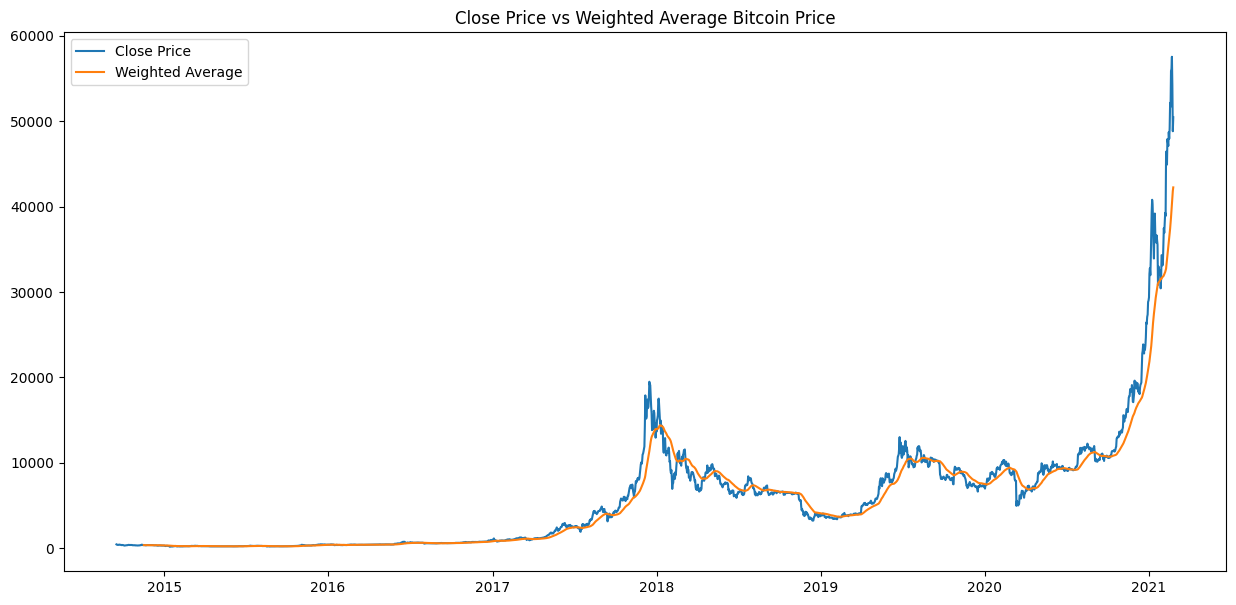

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(weighted_avg["market_date"], weighted_avg["close_price"], label="Close Price")
plt.plot(
    weighted_avg["market_date"], weighted_avg["weighted_avg"], label="Weighted Average"
)
plt.legend()
plt.title("Close Price vs Weighted Average Bitcoin Price")
plt.show();

## Exponential Weighted Average Close Price

The exponential moving average at time $t$  is given by:

$$
\begin{align*}
EMA_{t} = \lambda \cdot x_t + (1 - \lambda) \cdot EMA_{t-1}
\end{align*}
$$

where

* $x_t$ is the value of the time series at time $t$
* $EMA_{t-1}$ is the exponential moving average of the time series at time $t-1$
* $\lambda$ is the smoothing factor at time $t$

To find the EMA most similar to a moving average with a window of $n$ days, we can use the formula:

$$
\begin{align*}
\lambda = \frac{2}{n + 1}
\end{align*}
$$

The proof for this equation is given in the book [Smoothing, Forecasting and Prediction](https://www.amazon.com/Smoothing-Forecasting-Prediction-Discrete-Time/dp/0138153086) by Robert Goodell Brown.

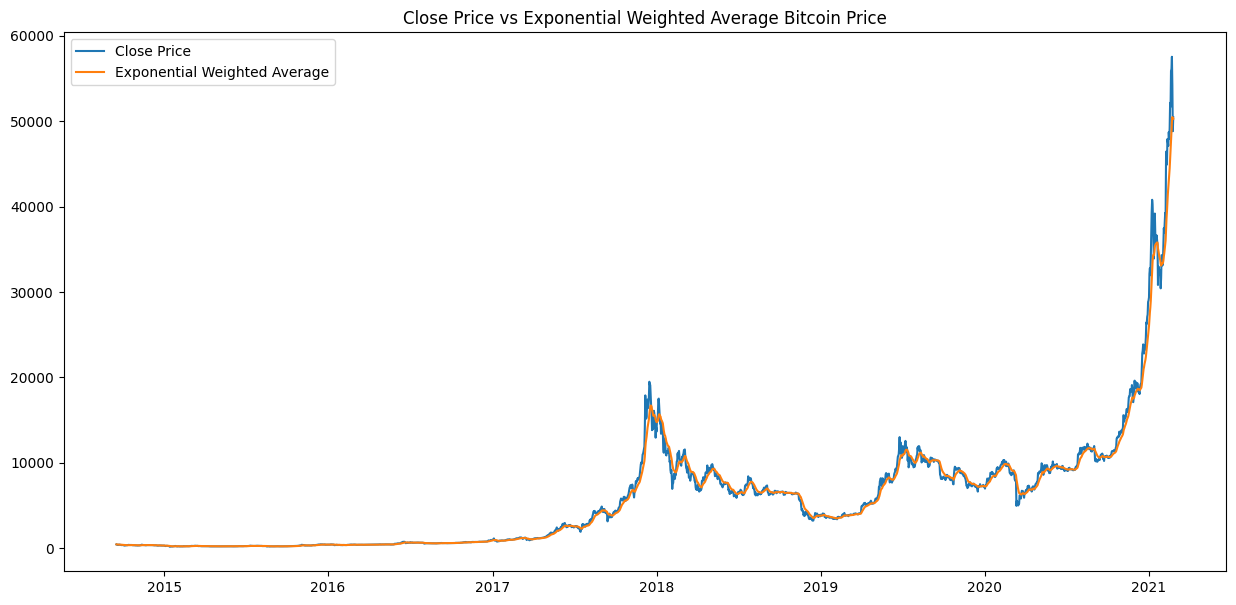

In [15]:
query = """
SELECT
    market_date,
    close_price
FROM
    trading.updated_daily_btc;
"""

close_price = athena.query(database=database, query=query, ctas_approach=ctas_approach)

window_size = 14

# Calculate the smoothing factor λ
smoothing_factor = 2 / (window_size + 1)

# Compute the exponential weighted average (EWA) for the 'close_price' column
close_price["ewa_close_price"] = (
    close_price["close_price"].ewm(alpha=smoothing_factor, adjust=False).mean()
)

fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(close_price["market_date"], close_price["close_price"], label="Close Price")
plt.plot(
    close_price["market_date"],
    close_price["ewa_close_price"],
    label="Exponential Weighted Average",
)
plt.legend()
plt.title("Close Price vs Exponential Weighted Average Bitcoin Price")
plt.show();

## Clean Up

In [16]:
athena.drop_view(database=database, view="updated_daily_btc", wait=wait)

Query executed successfully
